In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.layers import LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

C:\Users\maren\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### General notes
Need to save the original flow to compare predictions to > DONE

Currently I use lags as separate features, tho it might be more beneficial to use sequences (aka sequence becomes a single feature), so a new prediction is made based on the sequence of 24 past values
so use red data to predict the one blue datapoint
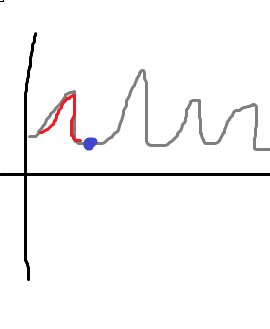

main issue: how to add extra features next to lags

# to do:
- do model without dummies
- fix scaling back to original scale

In [35]:
# new pickle data
data = pd.read_pickle('../../../data/model_data/Hertogenbosch (Helftheuvelweg).pickle')

# sort by time just in case
data = data.sort_values(by='datetime')

# drop everything unnecessary for now
new_data = data[['flow', 'rain_hour', 'level']]#, 'Weekday', 'Hour']] # removed month for now
new_data.head()

,flow,rain_hour,level
0,78200.2,0.0000,183594.268041
1,58077.5,0.0482,167662.429825
2,48555.5,0.3689,182493.419580
3,43946.1,0.0943,186665.067568
4,46307.2,0.0000,169907.055556


In [3]:
# basic metrics for original data
data[['flow']].describe()

,flow
count,13630.000000
mean,28441.994417
std,19852.263441
min,0.000000
25%,17143.900000
50%,26947.300000
75%,33441.550000
max,210000.000000


In [4]:
# normalize flow and rain columns

# first get numpy arrays of flow and rain so that the scaler can be applied
flow = np.array(new_data['flow']).reshape(-1, 1)
rain = np.array(new_data['rain_hour']).reshape(-1, 1)

# apply the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
flow = scaler.fit_transform(flow)
rain = scaler.fit_transform(rain)

# add columns back to df
new_data['norm_flow'] = flow
new_data['norm_rain'] = rain

# drop old flow and rain cols from df 
new_data = new_data.drop(['flow', 'rain_hour'], axis=1)

new_data.head()

C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\maren\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,norm_flow,norm_rain
0,0.372382,0.000000
1,0.276560,0.000358
2,0.231217,0.002737
3,0.209267,0.000700
4,0.220510,0.000000


In [5]:
def CreateLags(df, cols, lag_num):
    """
    Input:  df - df that you want to add lags to
            cols - list of names of the columns (str)
            lag_num - number of desired lags
    Output: 
    """
    shift_dfs = []
    for col in cols:
        # These are the "time lags"
        shifts = np.arange(1, lag_num+1).astype(int)
        # Use a dictionary comprehension to create name: value pairs, one pair per shift
        shifted_data_col = {col + "_lag_{}_hour".format(hour_shift): df[col].shift(hour_shift) for hour_shift in shifts}
        # Convert into a DataFrame for subsequent use
        col_shifts = pd.DataFrame(shifted_data_col)
        shift_dfs.append(col_shifts)
    # combine the shifted data with df
    df_shifted = pd.concat([df] + shift_dfs, axis=1)

    return df_shifted

In [6]:
# # create lags of flow and rain as features for the model
    
# # flow
# flow_lags = 24

# shifts = np.arange(1, flow_lags).astype(int)

# # Use a dictionary comprehension to create name: value pairs, one pair per shift
# shifted_data_hour = {"flow_lag_{}_hour".format(hour_shift): new_data.norm_flow.shift(hour_shift) for hour_shift in shifts}

# # Convert into a DataFrame for subsequent use
# flow_shifts = pd.DataFrame(shifted_data_hour)

# # rain
# rain_lags = 20
# # These are the "time lags"
# shifts = np.arange(1, rain_lags).astype(int)

# # Use a dictionary comprehension to create name: value pairs, one pair per shift
# shifted_data_rain = {"rain_lag_{}_hour".format(hour_shift): new_data.norm_rain.shift(hour_shift) for hour_shift in shifts}

# # Convert into a DataFrame for subsequent use
# rain_shifts = pd.DataFrame(shifted_data_rain)

# # combine the shifted data with old data
# new_data_shifted = pd.concat([new_data,flow_shifts,rain_shifts], axis=1)

new_data_shifted = CreateLags(new_data, ['norm_flow', 'norm_rain'], 24)

In [7]:
new_data_shifted.head()

,norm_flow,norm_rain,norm_flow_lag_1_hour,norm_flow_lag_2_hour,norm_flow_lag_3_hour,norm_flow_lag_4_hour,norm_flow_lag_5_hour,norm_flow_lag_6_hour,norm_flow_lag_7_hour,norm_flow_lag_8_hour,...,norm_rain_lag_15_hour,norm_rain_lag_16_hour,norm_rain_lag_17_hour,norm_rain_lag_18_hour,norm_rain_lag_19_hour,norm_rain_lag_20_hour,norm_rain_lag_21_hour,norm_rain_lag_22_hour,norm_rain_lag_23_hour,norm_rain_lag_24_hour
0,0.372382,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.276560,0.000358,0.372382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.231217,0.002737,0.276560,0.372382,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.209267,0.000700,0.231217,0.276560,0.372382,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.220510,0.000000,0.209267,0.231217,0.276560,0.372382,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# # get dummies for weekday and hour of the day and combine them with the data
# data_shift_dum = pd.get_dummies(new_data_shifted, columns = ['Weekday', 'Hour'])
# len1 = len(data_shift_dum)
# print('Shape before NAN removal: ', data_shift_dum.shape)

In [9]:
# drop NAN's
def DropNAN(df):
    len1 = len(df)
    print('Shape before NAN removal: ', df.shape)
    df.dropna(inplace=True)
    len2 = len(df)
    print('Shape after NAN removal:  ', df.shape)
    print(len1-len2, 'rows were removed')
    
    return df

In [10]:
def GetXY(df):
    # works assuming the predictor variable is the first column in df
    
    # create the X and y dataset
    X = df.iloc[:, 1:] # every columns exept current flow
    y = df.iloc[:, :1] # only the current flow columns
    
    # and make them into numpy arrays
    X = X.values
    y = y.values
    
    return X, y
    

In [11]:
# # create the X and y dataset
# X = data_shift_dum.iloc[:, 1:] # every columns exept current flow
# y = data_shift_dum.iloc[:, :1] # only the current flow columns

# # and make them into numpy arrays
# X = X.values
# y = y.values

In [12]:
ready_data = DropNAN(new_data_shifted)
ready_data = ready_data.drop(['norm_rain'], axis=1)
X, y = GetXY(ready_data)
ready_data.head()

Shape before NAN removal:  (13630, 50)
Shape after NAN removal:   (13606, 50)
24 rows were removed


,norm_flow,norm_flow_lag_1_hour,norm_flow_lag_2_hour,norm_flow_lag_3_hour,norm_flow_lag_4_hour,norm_flow_lag_5_hour,norm_flow_lag_6_hour,norm_flow_lag_7_hour,norm_flow_lag_8_hour,norm_flow_lag_9_hour,...,norm_rain_lag_15_hour,norm_rain_lag_16_hour,norm_rain_lag_17_hour,norm_rain_lag_18_hour,norm_rain_lag_19_hour,norm_rain_lag_20_hour,norm_rain_lag_21_hour,norm_rain_lag_22_hour,norm_rain_lag_23_hour,norm_rain_lag_24_hour
24,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,0.475200,0.348697,0.155275,0.176415,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0007,0.002737,0.000358,0.000000
25,0.203042,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,0.475200,0.348697,0.155275,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.000700,0.002737,0.000358
26,0.120231,0.203042,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,0.475200,0.348697,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000700,0.002737
27,0.092757,0.120231,0.203042,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,0.475200,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000700
28,0.178081,0.092757,0.120231,0.203042,0.308624,0.416750,0.556805,0.712757,0.736824,0.624386,...,0.000835,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000000


In [13]:
X.shape

(13606, 48)

In [14]:
443*24

10632

In [15]:
10632/13606

0.7814199617815669

In [16]:
data.iloc[443*24]

Unnamed: 0                       10922
day_ofthe_month                      1
hour                                 2
day_ofthe_year                      91
day_ofthe_week                       0
holiday                              0
flow                           11751.3
rain_hour                            0
level                           208103
rain_N_ago                           0
dates              2019-04-01 02:00:00
datetime           2019-04-01 02:00:00
Date                        2019-04-01
Weekday                         Monday
Hour                                 2
TimeOfDay                     02:00:00
Year                              2019
Month                            April
Day                                  1
DayofYear                           91
Name: 10632, dtype: object

In [17]:
2686/24/30

3.7305555555555556

In [18]:
13606/24/30

18.897222222222222

In [19]:
90*24/10632

0.20316027088036118

In [20]:
# split into train and test set
# here don't shuffle the data, so should have first 80% in train and rest in test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.78, test_size=.22, shuffle=False, random_state=1)

In [21]:
X_train.shape

(10612, 48)

In [22]:
n_hours = 24
n_features = 2

# reshape X_train and X_test for the LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], n_hours, n_features))
X_test = np.reshape(X_test, (X_test.shape[0], n_hours, n_features))

X_train.shape, X_test.shape

((10612, 24, 2), (2994, 24, 2))

In [23]:
n_hours

24

#### Start with model

In [24]:
model = Sequential()
model.add(LSTM(256, input_shape=(n_hours, n_features), return_sequences=True))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mae', metrics = ['mse', 'mae'], optimizer='adamax')
# model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1, shuffle=False)


Train on 8489 samples, validate on 2123 samples
Epoch 1/50
8489/8489 [==============================] - 38s 4ms/step - loss: 0.0631 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0631 - val_loss: 0.0588 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0588
Epoch 2/50
8489/8489 [==============================] - 35s 4ms/step - loss: 0.0553 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0553 - val_loss: 0.0563 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0563
Epoch 3/50
8489/8489 [==============================] - 34s 4ms/step - loss: 0.0548 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0548 - val_loss: 0.0548 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0548
Epoch 4/50
8489/8489 [==============================] - 34s 4ms/step - loss: 0.0529 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0529 - val_loss: 0.0516 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0516
Epoch 5/50
8489/8489 [==============

8489/8489 [==============================] - 34s 4ms/step - loss: 0.0287 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0287 - val_loss: 0.0358 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0358
Epoch 37/50
8489/8489 [==============================] - 33s 4ms/step - loss: 0.0285 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0285 - val_loss: 0.0349 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0349
Epoch 38/50
8489/8489 [==============================] - 33s 4ms/step - loss: 0.0288 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0288 - val_loss: 0.0350 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0350
Epoch 39/50
8489/8489 [==============================] - 33s 4ms/step - loss: 0.0283 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0283 - val_loss: 0.0353 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0353
Epoch 40/50
8489/8489 [==============================] - 34s 4ms/step - loss: 0.0282 - mean_

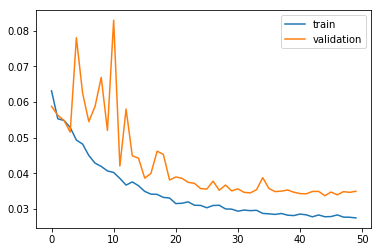

In [25]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [26]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [27]:
trainPredict.shape

(10612, 1)

In [28]:
max(trainPredict), min(trainPredict)

(array([0.7832471], dtype=float32), array([-0.01096981], dtype=float32))

In [29]:
# invert predictions

trainPredict2 = scaler.inverse_transform(trainPredict)
# reshape y_train so that can apply scaler
# y_train2 = np.reshape(y_train, (y_train.shape[0], ))
trainY = scaler.inverse_transform(y_train)

testPredict = scaler.inverse_transform(testPredict)
# same as before
# y_test2 = np.reshape(y_test, (y_test.shape[0], ))
testY = scaler.inverse_transform(y_test)

In [30]:
# trainPredict2 = scaler.inverse_transform(trainPredict)
# max(trainPredict2), min(trainPredict2)
max(trainY), min(trainY)

(array([134.7963]), array([0.]))

In [31]:
testY.shape

(2994, 1)

In [32]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# calculate mean absolute error
trainScore = round(mean_absolute_error(trainY[:,0], trainPredict[:,0]), 2)
print(f'Train Score: {trainScore} MAE')
testScore = round(mean_absolute_error(testY[:,0], testPredict[:,0]),2)
print(f'Test Score: {testScore} MAE')

Train Score: 22.34 RMSE
Test Score: 6.49 RMSE
Train Score: 18.23 MAE
Test Score: 4.38 MAE


(6350, 6500)

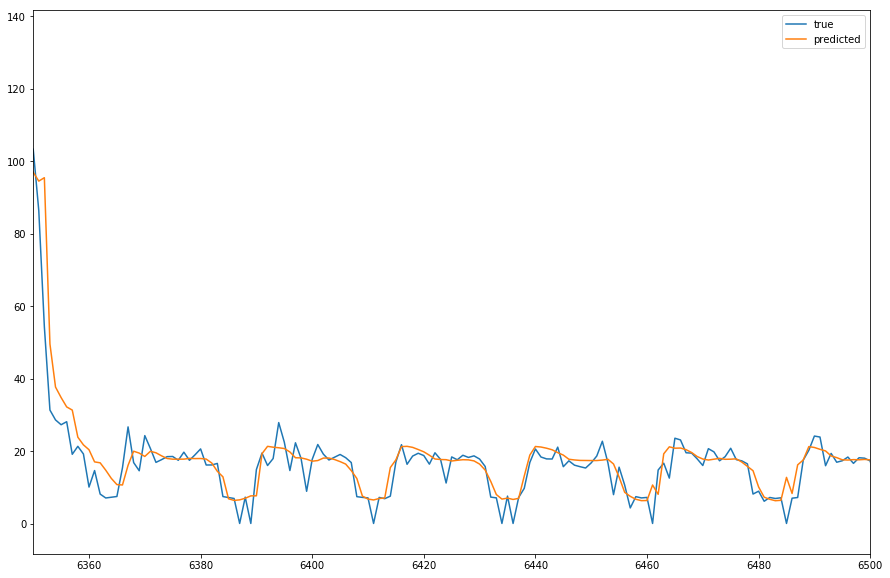

In [33]:
fig = plt.figure(figsize=(15,10))

plt.plot(trainY, label='true')
plt.plot(trainPredict2, label='predicted')
# plt.plot(testPredict)
plt.legend()
plt.xlim(6350, 6500)

### complete bullshit follows lol

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_shift_dum)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[24:len(trainPredict)+24, :] = trainPredict

NameError: name 'data_shift_dum' is not defined

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.show()

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_shift_dum)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(24*2)+1:len(data_shift_dum)-1, :] = testPredict
# plot baseline and predictions
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
org_flow = new_data['norm_flow'].to_numpy().reshape(-1, 1)
# org_flow = scaler.inverse_transform(org_flow)
# final = org_flow[23:]
# final.shape

In [ ]:
trainPredict.shape, testPredict.shape

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.show()

# results
- run without dummies i think
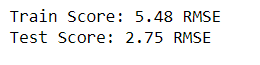

In [ ]:
for i in range(3, 0, -1):
    print(i)